D:\data\CT-Covid-19-August2020
D:\data\CT-Covid-19-August2020\volume-covid19-A-0005.nii\volume-covid19-A-0005.nii
0005
Origin: [-943.0, -189.083, -178.34]
Voxel Size: [1.0, 0.74, 0.74]
D:\data\CT-Covid-19-August2020\DRR_output\0005_source.npy
Saved.
D:\data\CT-Covid-19-August2020\DRR_output\0005_boneless.npy
Saved.
D:\data\CT-Covid-19-August2020\DRR_output\0005_lung.npy
Saved.
0005: Saving bone and lung segs for validation.
D:\data\CT-Covid-19-August2020\volume-covid19-A-0404.nii\volume-covid19-A-0404.nii
0404
Origin: [-352.0, -220.272, -213.436]
Voxel Size: [5.0, 0.862, 0.862]
D:\data\CT-Covid-19-August2020\DRR_output\0404_source.npy
Saved.
D:\data\CT-Covid-19-August2020\DRR_output\0404_boneless.npy
Saved.
D:\data\CT-Covid-19-August2020\DRR_output\0404_lung.npy
Saved.
0404: Saving bone and lung segs for validation.
D:\data\CT-Covid-19-August2020\volume-covid19-A-0612.nii\volume-covid19-A-0612.nii
0612
Origin: [-306.75, -180.0, -177.4]
Voxel Size: [5.0, 0.703125, 0.703125]
D:\data\CT-C

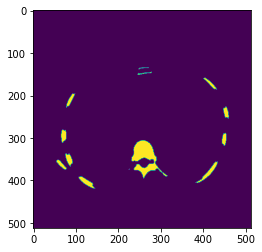

In [1]:
%matplotlib inline
import SimpleITK as sitk
import numpy as np
import os, sys, time, datetime
import pathlib
import re
import matplotlib.pyplot as plt


import skimage.filters, skimage.exposure, skimage.measure, skimage.morphology
import scipy

# Build DRR from the CT image NP array
import DRR
import ImageProcessing

# ALL CT IMAGES IN DIRECTORY
directoryPath = pathlib.Path("D:/data/CT-Covid-19-August2020/")
print(directoryPath)

path_to_file = []
for root, dirs, files in os.walk(directoryPath):
    for name in files:
        if name.endswith(".nii"):
            path_to_file.append(os.path.join(root, name))
            
save_directory = os.path.join(directoryPath,"DRR_output")
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# CSV file saved things
source_file = []
boneless_file = []
lung_file = []
PixelSize_i = []
PixelSize_j = []
origin_i = []
origin_j = []


# IMPORT FILE
for ii in [5, 366, 565]:#range(6): #range(len(path_to_file)):
    a_filepath = path_to_file[ii]
    print(a_filepath)
    head, tail = os.path.split(a_filepath)
    patient_code_file = os.path.splitext(tail)[0]

    regex = re.compile(r'(?<=-)[0-9_]+')
    patient_code = regex.findall(patient_code_file)[0]
    print(patient_code)
    
    reader = sitk.ImageFileReader()
    reader.SetFileName(a_filepath)
    reader.LoadPrivateTagsOn()
    reader.ReadImageInformation()
    # Read Metadata

    for k in reader.GetMetaDataKeys():
        v = reader.GetMetaData(k)
        #print(f"({k}) = = \"{v}\"")

    image = reader.Execute();

    # Properties are [CxHxW]
    VoxelSize = list( map( float, [reader.GetMetaData('pixdim[3]'), reader.GetMetaData('pixdim[1]'), reader.GetMetaData('pixdim[2]')]) )
    ImOrigin = list( map( float, [reader.GetMetaData('qoffset_z'), reader.GetMetaData('qoffset_y'), reader.GetMetaData('qoffset_x')]) )
    ImOrigin[1],ImOrigin[2] = -ImOrigin[1], -ImOrigin[2]
    print("Origin: "+ str(ImOrigin))
    print("Voxel Size: " + str(VoxelSize))
    
    # Generate DRR based on image
    nda = sitk.GetArrayFromImage(image)
    
    nda = np.maximum(nda,-1000) #Air
    nda = np.minimum(nda,1000) #Cortical bone
    
    ###########################
    # IMAGE PRE-PROCESSING
    ###########################

    # BODY MASKING
    # Use Otsu thresholding to distinguish body structures v.s. air
    th = skimage.filters.threshold_otsu(nda, nbins=256)
    mask = nda.copy() > th
    
    # Use morphological opening to carve away regions where body structure is linked to bed.
    # Erosion
    strel=skimage.morphology.ball(3)
    mask = skimage.morphology.erosion(mask, selem=strel)
    # CC Labelling
    mask, maxarea,_ = ImageProcessing.connectedComponentsLabelling(mask, connectivity=1, k=1)
    # Dilation
    mask = skimage.morphology.dilation(mask, selem=strel)

    # Hole Filling
    for i in range(mask.shape[0]):
        mask[i,:,:] = scipy.ndimage.binary_fill_holes(mask[i,:,:])


    nda_nobed = nda.copy()
    nda_nobed[~mask.astype('bool')]=-1024

    # BONE segmentation
    bone = ImageProcessing.BoneSegmentation(nda_nobed)
    nda_nobone = nda_nobed.copy()
    nda_nobone[bone.astype('bool')]=0  # that of water
    

    # LUNG segmentation
    lung = ImageProcessing.LungSegmentation(nda_nobed, mask)
    nda_lung = lung.astype(np.int16) * nda_nobed
    nda_lung[~lung.astype('bool')]=-1024  # that of water
    
    plt.imshow(bone[30,:,:])
    plt.plot
    #################################
    # SAVE OUTPUT
    #################################
    # Save the numpy arrays
    for status in ["source","boneless","lung"]:
        save_file_path = os.path.join(save_directory,patient_code+"_"+status+".npy")
        if status == "source":
            save_array = nda
        elif status == "boneless":
            save_array = nda_nobone
        elif status == "lung":
            save_array = nda_lung
            
        window_width = 2000
        window_level = 0
        save_out, PixelSize, origin = DRR.createDRR(save_array , 1, VoxelSize, ImOrigin, window_width, window_level)

        print(save_file_path)
        np.save(save_file_path, save_out, allow_pickle=False)
        print("Saved.")
    
    # Save data in lists
    source_file.append(os.path.join(save_directory,patient_code+"_"+"source"+".npy"))
    boneless_file.append(os.path.join(save_directory,patient_code+"_"+"boneless"+".npy"))
    lung_file.append(os.path.join(save_directory,patient_code+"_"+"lung"+".npy"))
    PixelSize_i.append(PixelSize[0])
    PixelSize_j.append(PixelSize[1])
    origin_i.append(origin[0])
    origin_j.append(origin[1])
    
    if patient_code=='0005' or patient_code=='0404' or patient_code=='0612':
        print(patient_code+': Saving bone and lung segs for validation.')
        save_directory_autoseg = os.path.join(directoryPath,"auto_segmentation")
        if not os.path.exists(save_directory_autoseg):
            os.makedirs(save_directory_autoseg)
        save_file_path_bone_autoseg = os.path.join(save_directory_autoseg, patient_code+"_"+"bone_autosegmentation"+".npy")
        np.save(save_file_path_bone_autoseg, bone, allow_pickle=False)
        save_file_path_lung_autoseg = os.path.join(save_directory_autoseg, patient_code+"_"+"lung_autosegmentation"+".npy")
        np.save(save_file_path_lung_autoseg, lung, allow_pickle=False)
        

# Save as a CSV with file paths
# source file | boneless file | lung file
import pandas as pd

# Write down the filepaths, pixel sizes, origins
data_dict = {'source': source_file, 'boneless': boneless_file, 'lung': lung_file, 
             'PixelSize_i': PixelSize_i, 'PixelSize_j': PixelSize_j, 
             'origin_i': origin_i, 'origin_j': origin_j}
df = pd.DataFrame(data_dict)

In [2]:
csv_file_name = "DRR_directory.csv"
df.to_csv(os.path.join(save_directory, csv_file_name), index=False)

D:\data\CT-Covid-19-August2020\DRR_output\0005_source.npy


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0.020609502189756813
1.0928287946718749


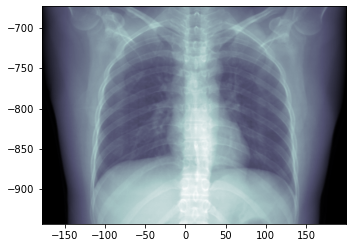

In [3]:
%matplotlib widget
#print(maxarea2/maxarea1)

ii = 0
print(df['source'][ii])

a = np.load(df['source'][ii])
ImageProcessing.plotImage(a , [df['PixelSize_i'][ii], df['PixelSize_j'][ii]] , [df['origin_i'][ii], df['origin_j'][ii]])
print(np.amin(a))
print(np.amax(a))

In [4]:
# REGEX TESTING
path_to_file = []
for root, dirs, files in os.walk(directoryPath):
    for name in files:
        if name.endswith(".nii"):
            path_to_file.append(os.path.join(root, name))
codes=[]
for a_filepath in path_to_file:
    head, tail = os.path.split(a_filepath)
    patient_code_file = os.path.splitext(tail)[0]


    regex = re.compile(r'(?<=-)[0-9_]+')
    patient_code = regex.findall(patient_code_file)[0]
    codes.append(patient_code)

# Search codes for 404
codes.index("0612")


565

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<function matplotlib.pyplot.plot>

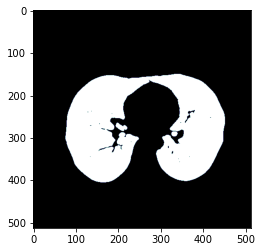

In [5]:
plt.imshow(lung[35,:,:])
plt.plot